# Mean field Floquet dynamics
Consider the Hamiltonian of the type
\begin{equation}
\hat{H}(t) = \hat{H}_0 + \left(h \cos{(\omega t)} + h_0\right)\; \hat{H}_1,
\end{equation}

where

\begin{eqnarray}
\hat{H}_0 &=& -\frac{1}{2N}\sum_{ij}\hat{\sigma}^z_i\hat{\sigma}^z_j,\\
\hat{H}_1 &=& \sum_i\hat{\sigma}^x_i.
\end{eqnarray}

Here, we have $N$ spin-$1/2$ particles in a $1-$dimensional lattice, and $i,j$ are site indices. We will now attempt a numerical evaluation of
the Floquet eigenspectrum of this system.

First, define permutation operator $P_{ij} = \displaystyle\frac{1}{2}\left(1+ \vec{\sigma}_i\cdot\vec{\sigma}_j\right)$,
and note that $[P_{ij}, H]=0$. Thus, we can reduce the problem size from the full $2^N\times 2^N$ Hilbert space
to the subspace spanned by the degenerate eigenvectors of $P_{ij}$ corresponding to a single eigenvalue, say $1$.
This is isomorphic to the subspace spanned by degenerate eigenstates of the operator $S^2=|\vec{S}|^2$ with eigenvalue
$\displaystyle\frac{N}{2}\left(\frac{N}{2}+1\right)$, where

\begin{equation}
\vec{S}=S^x\hat{x}+S^y\hat{y}+S^z\hat{z}\equiv \sum_i \vec{\sigma}_i.
\end{equation}

Note that, since $[S^2, S^z]=0$, these are also eigenstates of $S^z$ in this so-called
TSS subspace. The corresponding eigenvalues are $Ns_n$, where $s_n=-\frac{1}{2}+\frac{n}{N}$ and the index
$n= 0 (1) N$ has $N+1$ values. Thus

\begin{equation}
S^z |s_n\rangle = Ns_n|s_n\rangle,
\end{equation}

and the matrix elements $(S^z)_{ij} = Ns_s\delta_{ij}$. Furthermore, defining ladder operators

\begin{equation}
S_\pm \equiv S^x \pm i S^y,
\end{equation}

and using the result

\begin{equation}
S_\pm |s_n\rangle = \sqrt{\frac{N}{2}\left(\frac{N}{2}+1\right) - Ns_n\left(Ns_{n\pm 1}\right)}\;\;|s_{n\pm 1}\rangle,
\end{equation}

we can obtain the matrix elements $S^x = S_+ + S_-$ to be

\begin{multline}
(S^x)_{nm} = \frac{1}{2}\bigg[\sqrt{\frac{N}{2}\left(\frac{N}{2}+1\right) - Ns_n\left(Ns_{n + 1}\right)}\;\;\delta_{n+1, m}  \\
                        +\;\sqrt{\frac{N}{2}\left(\frac{N}{2}+1\right) - Ns_n\left(Ns_{n- 1}\right)}\;\;\delta_{n-1,m}\bigg]
\end{multline}

Note that, since the Hamiltonian can be readily written as
$H(t) = -\displaystyle\frac{1}{2N}(S^z)^2 - h_0\cos{(\omega t )}S^x$, the matrix elements of
\begin{eqnarray}
\left(H_0\right)_{ij} &=& -\frac{N}{2} s^2_i \delta_{ij},\nonumber\\
\left(H_1\right)_{ij} &=& \frac{1}{2}\bigg[\sqrt{\frac{N}{2}\left(\frac{N}{2}+1\right) - Ns_i\left(Ns_{i + 1}\right)}\;\;\delta_{i+1, j}  \\
    & &                     +\;\sqrt{\frac{N}{2}\left(\frac{N}{2}+1\right) - Ns_i\left(Ns_{i- 1}\right)}\;\;\delta_{i-1,j}\bigg]
\end{eqnarray}

Note that, in the continuum limit, $N\rightarrow\infty$, we can ignore the difference between adjacent values
of $s_i$. Thus, the Hamiltonian per particle becomes $h(t)\equiv \displaystyle\frac{1}{N}H(t) = h + h_0\cos{(\omega t)}h_1$, where

\begin{eqnarray}
\left(h\right)_{ij} &\approx& -\frac{1}{2} s^2_i \delta_{ij},\nonumber\\
h_0 &\rightarrow& -\frac{1}{2}s^2\\
\left(h_1\right)_{ij} &\approx& \frac{1}{2}\sqrt{\frac{1}{4} - s^2_i}\left[\delta_{i+1, j}  + \delta_{i-1,j}\right]\\
h_1 &\rightarrow& \sqrt{\frac{1}{4} - s^2_i}\;\;\cos{p},
\end{eqnarray}
where we have expanded the matrix elements in a basis of $e^{ipx}$. In this limit, we obtain the Lipkin Model (Insert from previous notebook)
.


References:

[1] Check T. Mori's paper equation (12)

In [ ]:
from floquet_spectrum import *
import numpy as np
import matplotlib.pyplot as plt

start =time.time()

N = 6
nprocs=N

s = -0.5 + (1./N) * np.arange(N)

h0 = np.diagflat(-0.5 * (N * s)**2)

def delta_func(x,y):
    if ( x == y ):
        return 1.0
    else:
        return 0.0
    

sup_diag = np.array([np.sqrt((N/2)*(1. + N/2) - N**2 * s[i] * s[i+1]) for i in range(N-1)])
sub_diag = np.array([np.sqrt((N/2)*(1. + N/2) - N**2 * s[i] * s[i-1]) for i in range(N-1)])
h1 = np.diagflat(sup_diag, k=1) + np.diagflat(sub_diag, k=-1)

omega = 40.0
amps = np.linspace(10.0,70, 50)
dc = 0.1
params = {"omega": omega, "amps": amps, "dc": dc, "hamilt": (h0, h1)}
output = run_floquet(params)

print("time taken",time.time() - start,"second")

# Lets plot it

ampp = (np.ones((N,len(amps)))*amps).T
#plt.figure(figsize=(12,6))

for i in np.arange(len(amps)):
    plt.scatter(4*ampp[i]/omega,np.log(output[i][1]) * (-1j * omega/2 * np.pi),color='blue', marker='.', s= 0.8)

title = "floquet dynamics for N_"+ str(N)
plt.title(title)
plt.xlabel("4h/w")
plt.ylabel("phase function")
plt.show()

## To get another view of the floquet dynamics I have introduced a different algorithm.


Here I have rewritten H0 in another form. 

### 1. scatter plot

running for N =  16 with 3 processors
time taken 3.171287469069163 minute


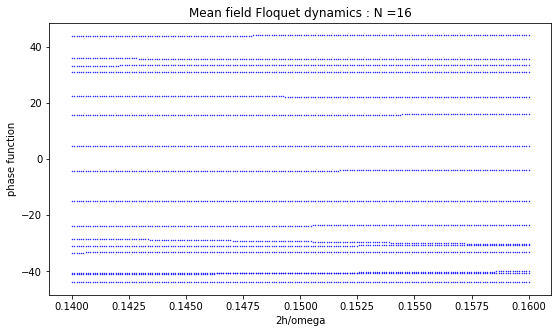

In [1]:
## experiment

#  THIS CODE IS DONE FOR NEWER HAMILTONIAN. THE QUASI-ENREGY ARE PLOTTED WITH SCATTER PLOT I.E. WE HAVE PLOTTED
#  ALL THE QUASI-ENERGIES IN A SCATTER PLOT FOR EACH "h". THIS WORKS ARE FOLLOWS. WE HAVE TAKEN EACH OF CHOSEN
#  h FROM "hs" AND THEN WE CALCUALTED "N" NUMBER OF QUASI-ENERGIS FOR A SPIN SYSTEM CONSISTED OF "N" NUMBER OF 
#  1D SPIN.


import numpy as np
from odeintw import odeintw
import matplotlib.pyplot as plt
from multiprocessing import Pool
from numpy.linalg import multi_dot, norm, eig
import math
import time

start = time.time()

N = 16 
h0 = 0.1
omega = 40.0
w = omega
tsteps = 500
hsteps = 200
hs = np.linspace(2.8,3.2,hsteps)
ampp = (np.ones((N,len(hs))) * hs).T
psi = np.eye(N) + 1j * np.zeros((N,N))
floqEvolution_mat = np.zeros((N,N)) + 1j * np.zeros((N,N))

title = "Mean field Floquet dynamics : N =" + str(N)
filename = 'mfd_fl_'+str(N) +'imag.jpeg'
filename1 = 'mfd_fl_'+str(N) +'real.jpeg'

def floq_jac(psi0, t, h, h0, H1, H0, w):    
    drive = h0 + h * np.cos(w * t)
    jac = 1j * N * (H0 + drive * H1)    
    return jac
        
def floq_func(psi0, t, h, h0, H1, H0, w):
    floq_h = np.dot(floq_jac(psi0, t, h, h0, H1, H0, w), psi0)
    return floq_h

def floq_evolv(psi,H0,H1,h,w):
    T = 10 * 2 * np.pi/w           # this is equivalent to single time period accoding to Floquet theory                                 
    t = np.linspace(0,2 * np.pi/w,tsteps)                      
    floqEvolution_mat = np.zeros((N,N)) + 1j * np.zeros((N,N))
    
    for m in np.arange(N):
        psi0 = psi[m]
        psi_t = odeintw(floq_func,psi0,t,args=(h, h0, H1, H0, w))
        floqEvolution_mat[m] = psi_t[-1]                 
    evals, evecs = eig(floqEvolution_mat)
    phasefunc = 1j * 2.303 * np.log(evals + 1j * 0) * omega/(2 * np.pi)
    return phasefunc.real
    
if __name__ == '__main__':
    nprocs = 3
    p = Pool(processes = nprocs)          
    print("running for N = ", N, "with",nprocs,"processors")
    start = time.time()       

    s = -0.5 + (1./N) * np.arange(N)
    #H0 =  np.diagflat(0.5 * (N * s) ** 2.0)
    H0 = np.array([0.5 * N * N * s[i] * s[j] for i in range(N) for j in range(N)]).reshape((N,N))
    
    sup_diag = np.array([np.sqrt((N/2)*(1. + N/2) - N**2 * s[i] * s[i+1]) for i in range(N-1)])
    sub_diag = np.array([np.sqrt((N/2)*(1. + N/2) - N**2 * s[i] * s[i-1]) for i in range(N-1)])
    H1 = np.diagflat(sup_diag, k=1) + np.diagflat(sub_diag, k=-1)   
    
    data = p.starmap(floq_evolv,[(psi,H0,H1,h,w) for h in hs])
    
    print('time taken',(time.time()-start)/60.0,'minute')
    
    plt.figure(figsize = (9,5))
    for xx in np.arange(len(hs)):
        plt.scatter(2 * ampp[xx]/omega, data[xx], color = 'blue', marker='.', s = 0.8)
    plt.title(title)    
    plt.xlabel("2h/omega")
    plt.ylabel("phase function")
    plt.show()

running for N =  8 with 3 processors
time taken 7.8281478921572365 minute


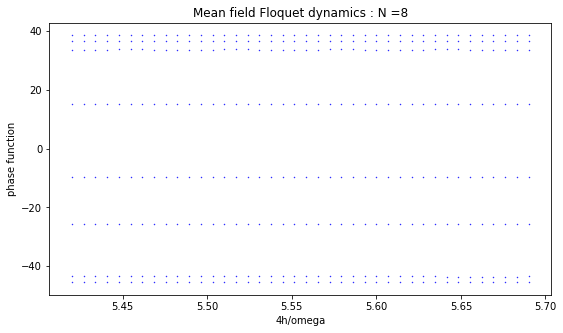

In [2]:
# experimetn  22

## experiment

#  THIS CODE IS DONE FOR NEWER HAMILTONIAN. THE QUASI-ENREGY ARE PLOTTED WITH SCATTER PLOT I.E. WE HAVE PLOTTED
#  ALL THE QUASI-ENERGIES IN A SCATTER PLOT FOR EACH "h". THIS WORKS ARE FOLLOWS. WE HAVE TAKEN EACH OF CHOSEN
#  h FROM "hs" AND THEN WE CALCUALTED "N" NUMBER OF QUASI-ENERGIS FOR A SPIN SYSTEM CONSISTED OF "N" NUMBER OF 
#  1D SPIN.


import numpy as np
from odeintw import odeintw
import matplotlib.pyplot as plt
from multiprocessing import Pool
from numpy.linalg import multi_dot, norm, eig
import math
import time

start = time.time()

N = 8 
h0 = 0.1
omega = 40.0
w = omega
tsteps = 500
hsteps = 40
hs = np.linspace(54.2,56.9,hsteps)
ampp = (np.ones((N,len(hs))) * hs).T
psi = np.eye(N) + 1j * np.zeros((N,N))
floqEvolution_mat = np.zeros((N,N)) + 1j * np.zeros((N,N))

title = "Mean field Floquet dynamics : N =" + str(N)
filename = 'mfd_fl_'+str(N) +'imag.jpeg'
filename1 = 'mfd_fl_'+str(N) +'real.jpeg'

def floq_jac(psi0, t, h, h0, H1, H0, w):    
    drive = h0 + h * np.cos(w * t)
    jac = 1j * N * (H0 + N * drive * H1)    
    return jac
        
def floq_func(psi0, t, h, h0, H1, H0, w):
    floq_h = np.dot(floq_jac(psi0, t, h, h0, H1, H0, w), psi0)
    return floq_h

def floq_evolv(psi,H0,H1,h,w):
    T = 1 * 2 * np.pi/w           # this is equivalent to single time period accoding to Floquet theory                                 
    t = np.linspace(0,2 * np.pi/w,tsteps)                      
    floqEvolution_mat = np.zeros((N,N)) + 1j * np.zeros((N,N))
    
    for m in np.arange(N):
        psi0 = psi[m]
        psi_t = odeintw(floq_func,psi0,t,args=(h, h0, H1, H0, w))
        floqEvolution_mat[m] = psi_t[-1]                 
    evals, evecs = eig(floqEvolution_mat)
    phasefunc = 1j * 2.303 * np.log(evals + 1j * 0) * omega/(2 * np.pi)
    return phasefunc

if __name__ == '__main__':
    nprocs = 3
    p = Pool(processes = nprocs)          
    print("running for N = ", N, "with",nprocs,"processors")
    start = time.time()       

    #s = -0.5 + (1./N) * np.arange(N)
    s = np.linspace(-.5 , .5 ,N)
    #H0 =  np.diagflat(0.5 * (N * s) ** 2.0)
    H0 = np.array([0.5 * N * N * s[i] * s[j]\
                   for i in range(N) for j in range(N)]).reshape((N,N))    
    H1 = np.array([0.5 * np.sqrt((N/2)*(1. + N/2) - N**2 * s[i] * s[j])\
                  for i in range(N) for j in range(N)]).reshape((N,N))
    
    for l in range(N):
        H0[l][l] = 0.0
        H1[l][l] = 0.0
        
    data = p.starmap(floq_evolv,[(psi,H0,H1,h,w) for h in hs])
    
    print('time taken',(time.time()-start)/60.0,'minute')
    
    plt.figure(figsize = (9,5))
    for xx in np.arange(len(hs)):
        plt.scatter(4 * ampp[xx]/omega, data[xx].real,\
                    color = 'blue', marker='.', s = 0.8)
    plt.title(title)    
    plt.xlabel("4h/omega")
    plt.ylabel("phase function")
    plt.show()

In [16]:
# experiment  2255

# note : here  I have tried to introduce the average of phasefunc and its variations

import numpy as np
from odeintw import odeintw
import matplotlib.pyplot as plt
from multiprocessing import Pool
from numpy.linalg import multi_dot, norm, eig
import math
import time
start = time.time()


N = 20
kacN = 20
h0 = 0.1
omega = 100.0
w = omega
tsteps = 500
hsteps = 1000
hs = np.linspace(5.515, 5.525, hsteps)
ampp = (np.ones((N,len(hs))) * hs).T
psi = np.eye(N) + 1j * np.zeros((N,N))
floqEvolution_mat = np.zeros((N,N)) + 1j * np.zeros((N,N))
H0 = np.zeros((N,N))
H1 = np.zeros((N,N))

def delta_func(x,y):
        if ( x == y ):
            return 1.0
        else:
            return 0.0
        
def floq_jac(psi0, t, h, h0, H1, H0, w):    
    drive = h0 + h * np.cos(w * t)
    jac = 1j * N * (H0 + drive * H1)    
    return jac
        
def floq_func(psi0, t, h, h0, H1, H0, w):
    floq_h = np.dot(floq_jac(psi0, t, h, h0, H1, H0, w), psi0)
    return floq_h

def floq_evolv(psi,H0,H1,h,w):
    T = 2 * np.pi/w                                    
    t = np.linspace(0,2 * np.pi/w,tsteps)                      
    floqEvolution_mat = np.zeros((N,N)) + 1j * np.zeros((N,N))
    
    for m in np.arange(N):
        psi0 = psi[m]
        psi_t = odeintw(floq_func,psi0,t,args=(h, h0, H1, H0, w))
        floqEvolution_mat[m] = psi_t[-1]     
    #print('unitary or not', np.dot(np.conjugate(floqEvolution_mat).T,floqEvolution_mat).real)    
    evals, evecs = eig(floqEvolution_mat)
    phasefunc = 1j  * np.log(evals + 1j * 0) * omega/(2 * np.pi)
    return phasefunc

if __name__ == '__main__':
    nprocs = 3
    p = Pool(processes = nprocs)          
    print("running for N = ", N, "with",nprocs,"processors")
    start = time.time()       
   
    spin = 0.5 * np.arange(N)[-1]
    s = np.arange(-spin,spin+1) 
    H0 = np.diagflat(0.5 * s **2/kacN)
    #H0 = np.diagflat(0.5 * s * (s+1))
    #H0 = np.array([0.5 *  s[i] * s[j]for i in range(N) for j in range(N)]).reshape((N,N))   
    for i in range(N):
        for j in range(N):
            H1[i][j] = 0.5 * (np.sqrt(spin * (spin+1) - s[i] * (s[i]+1)) * delta_func(s[j],s[i]+1)\
                              + np.sqrt(spin * (spin+1) - s[i] * (s[i]-1)) * delta_func(s[j],s[i]-1))
    
    #print('H0 is----- \n',H0,'\nH1 is----- \n',H1,'\n')
    
    data = p.starmap(floq_evolv,[(psi,H0,H1,h,w) for h in hs])    
    print('time taken',(time.time()-start)/60.0,'minute')

running for N =  20 with 3 processors
time taken 5.556933852036794 minute


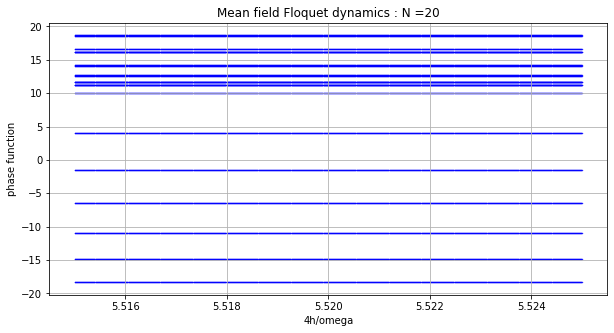

In [18]:
    title = "Mean field Floquet dynamics : N =" + str(N)
    plt.figure(figsize = (10,5))
    for xx in np.arange(len(hs)):
        plt.scatter(2 * ampp[xx]* kacN/omega, data[xx].real,\
                    color = 'blue', marker='.', s = 0.8)
    plt.title(title)    
    plt.xlabel("4h/omega")
    plt.ylabel("phase function")
    plt.grid()
    plt.show()

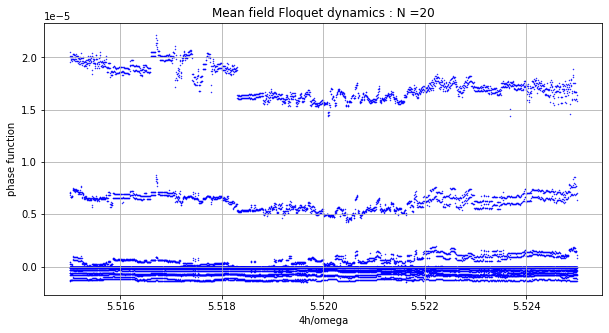

In [19]:
    title = "Mean field Floquet dynamics : N =" + str(N)
    plt.figure(figsize = (10,5))
    for xx in np.arange(len(hs)):
        plt.scatter(2 * ampp[xx]* kacN/omega, data[xx].imag,\
                    color = 'blue', marker='.', s = 0.8)
    plt.title(title)    
    plt.xlabel("4h/omega")
    plt.ylabel("phase function")
    plt.grid()
    plt.show()

(1000, 20) (1000,)


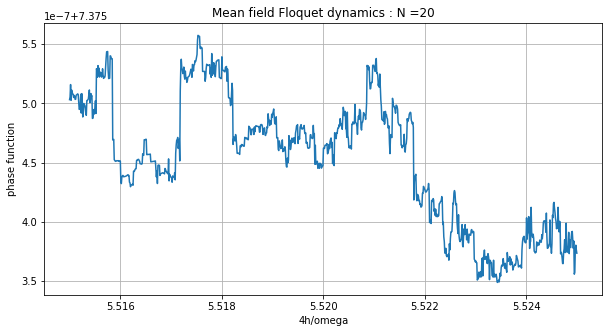

In [21]:
    plt.figure(figsize = (10,5))
    print(np.shape(data),np.shape(hs))
    avg = np.zeros(len(hs))
    for i in np.arange(len(hs)):
        avg[i] = np.average(data[i].real)
    #print(avg)
    #for xx in np.arange(len(hs)):
        #plt.scatter(4 * hs/omega, avg,\
        #            color = 'blue', marker='.', s = 0.5)
    plt.plot(2 * hs * kacN/omega, avg)
    plt.title(title)    
    plt.xlabel("4h/omega")
    plt.ylabel("phase function")
    plt.grid()
    plt.show()

omega ranges in 250.0 & 222.22222222222223
running for N =  50 with 4 processors
time taken for data run 21.960926206906638 minute


 real plot ---


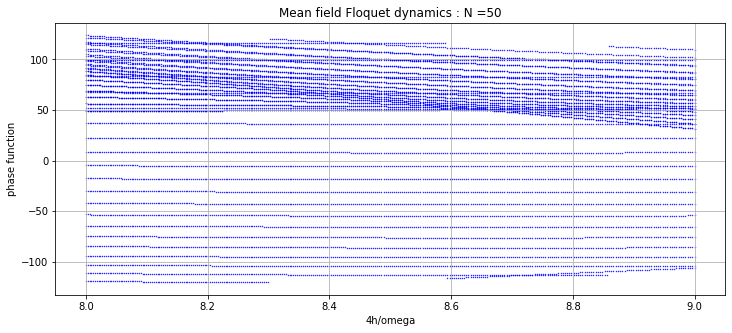

imaginary plot ---


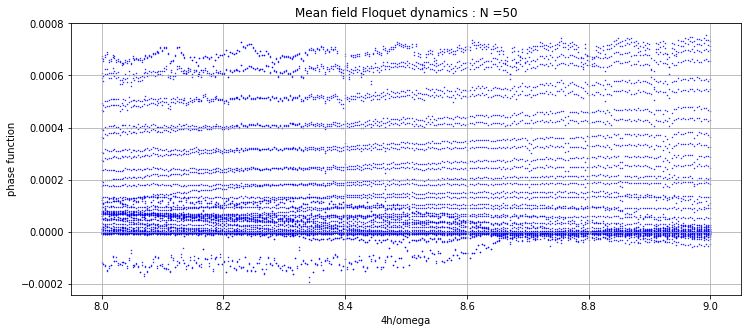

average real data plot ---
(300, 50) (300,)


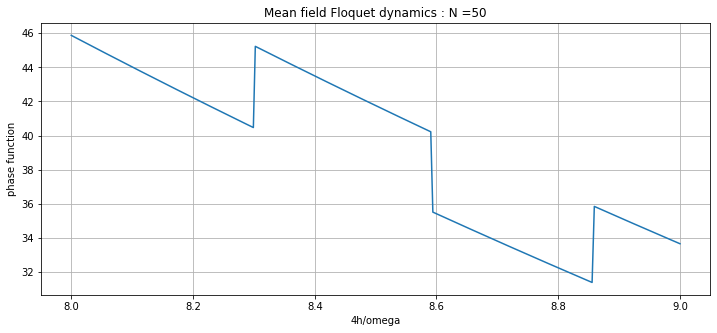

average imaginary data plot ---
(300, 50) (300,)


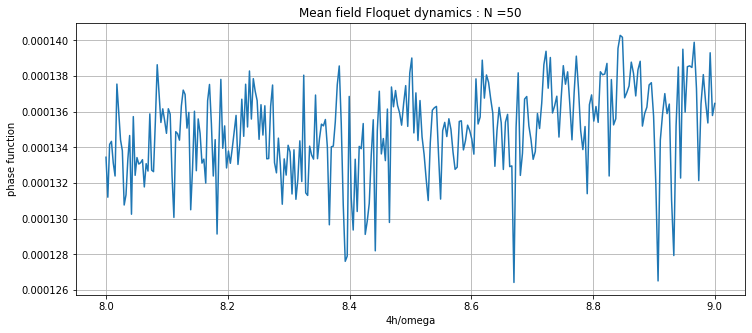

Total time taken 22.091324520111083 minute


In [6]:
## DEC 3 CODE


# note : here  I have tried to introduce the average of phasefunc and its variations
#              I also have changed the code in such a way that frequecy get varies
#              instead of amplitude of symmetry breaking field.

import numpy as np
from odeintw import odeintw
import matplotlib.pyplot as plt
from multiprocessing import Pool
from numpy.linalg import multi_dot, norm, eig
import math
import time
start = time.time()

# 2.40482555769577	5.52007811028631	8.65372791291101	11.7915344390142	14.9309177084877

N = 50
kacN = N
h0 = 0.1
h = 20.0
tsteps = 500
wsteps = 300
w1 = 2 * h * kacN / 8.
w2 = 2 * h * kacN / 9.
print('omega ranges in',w1,'&',w2)
ws = np.linspace(w1, w2, wsteps)
#ampp = (np.ones((N,len(hs))) * hs).T
wpp = (np.ones((N,len(ws))) * ws).T
psi = np.eye(N) + 1j * np.zeros((N,N))
floqEvolution_mat = np.zeros((N,N)) + 1j * np.zeros((N,N))
H0 = np.zeros((N,N))
H1 = np.zeros((N,N))

def delta_func(x,y):
        if ( x == y ):
            return 1.0
        else:
            return 0.0
        
def floq_jac(psi0, t, h, h0, H1, H0, w):    
    drive = h0 + h * np.cos(w * t)
    jac = 1j * N * (H0 + drive * H1)    
    return jac
        
def floq_func(psi0, t, h, h0, H1, H0, w):
    floq_h = np.dot(floq_jac(psi0, t, h, h0, H1, H0, w), psi0)
    return floq_h

def floq_evolv(psi,H0,H1,h,w):
    T = 2 * np.pi/w                                    
    t = np.linspace(0,2 * np.pi/w,tsteps)                      
    floqEvolution_mat = np.zeros((N,N)) + 1j * np.zeros((N,N))
    
    for m in np.arange(N):
        psi0 = psi[m]
        psi_t = odeintw(floq_func,psi0,t,args=(h, h0, H1, H0, w))
        floqEvolution_mat[m] = psi_t[-1]     
    #print('unitary or not', np.dot(np.conjugate(floqEvolution_mat).T,floqEvolution_mat).real)    
    evals, evecs = eig(floqEvolution_mat)
    phasefunc = 1j  * np.log(evals + 1j * 0) * w/(2 * np.pi)
    return phasefunc

if __name__ == '__main__':
    nprocs = 4
    p = Pool(processes = nprocs)          
    print("running for N = ", N, "with",nprocs,"processors")
    start = time.time()       
   
    spin = 0.5 * np.arange(N)[-1]
    s = np.arange(-spin,spin+1) 
    H0 = np.diagflat(0.5 * s **2/kacN)
    #H0 = np.diagflat(0.5 * s * (s+1))
    #H0 = np.array([0.5 *  s[i] * s[j]for i in range(N) for j in range(N)]).reshape((N,N))   
    for i in range(N):
        for j in range(N):
            H1[i][j] = 0.5 * (np.sqrt(spin * (spin+1) - s[i] * (s[i]+1)) * delta_func(s[j],s[i]+1)\
                              + np.sqrt(spin * (spin+1) - s[i] * (s[i]-1)) * delta_func(s[j],s[i]-1))
    
    #print('H0 is----- \n',H0,'\nH1 is----- \n',H1,'\n')
    
    data = p.starmap(floq_evolv,[(psi,H0,H1,h,w) for w in ws])    
    print('time taken for data run',(time.time()-start)/60.0,'minute')
    
    print('\n\n real plot ---')
    
    title = "Mean field Floquet dynamics : N =" + str(N)
    plt.figure(figsize = (12,5))
    for xx in np.arange(len(ws)):
        plt.scatter(2 * h* kacN /wpp[xx], data[xx].real,\
                    color = 'blue', marker='.', s = 0.8)
    plt.title(title)    
    plt.xlabel("4h/omega")
    plt.ylabel("phase function")
    plt.grid()
    plt.show()
    
    print('imaginary plot ---')
    
    title = "Mean field Floquet dynamics : N =" + str(N)
    plt.figure(figsize = (12,5))
    for xx in np.arange(len(ws)):
        plt.scatter(2 * h* kacN /wpp[xx], data[xx].imag,\
                    color = 'blue', marker='.', s = 0.8)
    plt.title(title)    
    plt.xlabel("4h/omega")
    plt.ylabel("phase function")
    plt.grid()
    plt.show()
    
    print('average real data plot ---')
    
    plt.figure(figsize = (12,5))
    print(np.shape(data),np.shape(ws))
    avg = np.zeros(len(ws))
    for i in np.arange(len(ws)):
        avg[i] = np.average(data[i].real)
    #print(avg)
    #for xx in np.arange(len(hs)):
        #plt.scatter(4 * hs/omega, avg,\
        #            color = 'blue', marker='.', s = 0.5)
    plt.plot(2 * h * kacN/ws, avg)
    plt.title(title)    
    plt.xlabel("4h/omega")
    plt.ylabel("phase function")
    plt.grid()
    plt.show()
    
    print('average imaginary data plot ---')
    
    plt.figure(figsize = (12,5))
    print(np.shape(data),np.shape(ws))
    avg = np.zeros(len(ws))
    for i in np.arange(len(ws)):
        avg[i] = np.average(data[i].imag)
    #print(avg)
    #for xx in np.arange(len(hs)):
        #plt.scatter(4 * hs/omega, avg,\
        #            color = 'blue', marker='.', s = 0.5)
    plt.plot(2 * h * kacN/ws, avg)
    plt.title(title)    
    plt.xlabel("4h/omega")
    plt.ylabel("phase function")
    plt.grid()
    plt.show()
    
    print('Total time taken',(time.time()-start)/60,'minute')

In [57]:
## work just here

import numpy as np
def delta_func(x,y):
        if ( x == y ):
            return 1.0
        else:
            return 0.0
N = 5
H1 = np.zeros((N,N))
spin = 0.5 * np.arange(N)[-1]
s = np.arange(-spin,spin+1)
ms = s * N 
H0 = np.diagflat(-0.5 * s **2)
#H00 = np.diagflat(-0.5 * s * (s+1))
#H0 = np.array([0.5 *  s[i] * s[j]for i in range(N) for j in range(N)]).reshape((N,N))   
for i in range(N):
    for j in range(N):
        H1 [i][j] = np.sqrt(spin * (spin+1) - s[i] * (s[i]+1)) * delta_func(s[j],s[i]+1)\
                        + np.sqrt(spin * (spin+1) - s[i] * (s[i]-1)) * delta_func(s[j],s[i]-1)


[-2. -1.  0.  1.  2.] 
 [[ 2.   1.  -0.  -1.  -2. ]
 [ 1.   0.5 -0.  -0.5 -1. ]
 [-0.  -0.   0.   0.   0. ]
 [-1.  -0.5  0.   0.5  1. ]
 [-2.  -1.   0.   1.   2. ]] 
 [[0.         2.         0.         0.         0.        ]
 [2.         0.         2.44948974 0.         0.        ]
 [0.         2.44948974 0.         2.44948974 0.        ]
 [0.         0.         2.44948974 0.         2.        ]
 [0.         0.         0.         2.         0.        ]]


### 2. "specific path" code

running for N =  6 with 4 processors
run starts !!
time taken 11.334733780225118 minute


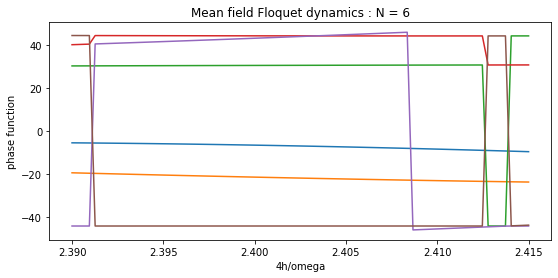

In [1]:
# try to write "specific path" code into MULTI PROCESS code


#   NOW WE GIVE A TRY TO PLOT QUASI ENERGIES FOR A SPECIFIC PATH.
#   ACCORDING TO FLOQUET THEORY, AN  N X N UNITARY MATRIX IS CHOSEN INITIALLY, LETS CALL IT "S" MATRIX. EACH OF THE COLOUM
#   OF S MATRIX IS TAKEN AS THE INITIAL WAVE FUNCTION FOR EVOLVE. AFTER ONE PERIOD or MULTIPLE OF PERIOD OF EVOLUTION WE GET
#    AN N X 1 DIMENSIONAL MATRIX WHICH IS THE WAVE FUNCITON DENOTING STATE OF THE SPIN SYSTEM AFTER ONE TIME PERIOD.
#    SIMILAR WAY WE COLLECT ALL OTHER "N" OF WAVE FUNCIOTN EACH WHICH IS BASICALLY COLUMN MATRIX. WE THEN BUILD ANOTHER N X N MATRIX.  
#   LETS CALL THIS MATRIX AS "U" MATRIX. THE EIGEN FUNCTION OF U MATRIX 

import numpy as np
from odeintw import odeintw
import matplotlib.pyplot as plt
from multiprocessing import Pool
from numpy.linalg import multi_dot, norm, eig
import math
import time

start = time.time() 

N = 6
h0 = 0.1
omega = 40
w = omega
tsteps = 500
hsteps = 80
T = 20 * 2 * np.pi/w              # this is equivalent to single time period accoding to Floquet theory
t = np.linspace(0,T,tsteps)

hs = np.linspace(23.9,24.15,hsteps)
ampp = (np.ones((N,len(hs)))*hs).T
psi = np.eye(N) + (1j) * np.zeros((N,N))
floqEvolution_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))
phasefunc_path = np.zeros(len(hs))

def delta_func(x,y):
        if ( x == y ):
            return 1.0
        else:
            return 0.0

def floq_jac(psi0, t, h, h0, H1, H0, w):    
    drive = h0 + h * np.cos(w * t)
    jac = 1j * N * (H0 + drive * H1)    
    return jac
        
def floq_func(psi0, t, h, h0, H1, H0, w):
    floq_h = np.dot(floq_jac(psi0, t, h, h0, H1, H0, w), psi0)
    return floq_h

def floq_proc(psi,H0,H1,hs,w,nn):
    pp = nn
    labelname = 'wave func_' + str(nn)
    filename = str(N) + '_wave_' + str(nn)+ '.txt'
    
    # calculate for first "h"
    h = hs[0]           
    floqEvolution_mat = np.zeros((N,N)) + 1j * np.zeros((N,N))
    for mm in np.arange(N):
        psi0 = psi[mm]  
        psi_t = odeintw(floq_func,psi0,t,args=(h, h0, H1, H0, w), Dfun=floq_jac)
        floqEvolution_mat[mm] = psi_t[-1]         
    evals, evecs = eig(floqEvolution_mat)
    evecs = np.asarray(list(map(lambda x :x/np.linalg.norm(x),evecs)))
    phasefunc = 2.303 * np.log(evals[nn] + 1j * 0) * 1j * omega/(2 * np.pi)
    evecs_path = evecs[nn]               
    phasefunc_path[0] = phasefunc.real
    
    # calculate for rest of the "h"
    for cc, h in enumerate(hs[1:len(hs)]):   
        floqEvolution_mat = np.zeros((N,N)) + 1j * np.zeros((N,N))        
        for mm in np.arange(N):
            psi0 = psi[mm]  
            psi_t = odeintw(floq_func,psi0,t,args=(h, h0, H1, H0, w), Dfun=floq_jac)
            floqEvolution_mat[mm] = psi_t[-1] 
        evals, evecs = eig(floqEvolution_mat)
        evecs = np.asarray(list(map(lambda x :x/np.linalg.norm(x),evecs)))
        prob = np.asarray(list(map(lambda x:np.dot(np.conjugate(evecs_path).T,x),evecs)))
        for i,pr in enumerate(prob):
            if (pr.real == max(prob.real)):
                pp = i
                break
        evecs_path = evecs[pp]
        phasefunc = 2.303 * np.log(evals[pp] + 1j * 0) * 1j * omega/(2 * np.pi)
        phasefunc_path[cc+1] = phasefunc.real
    return phasefunc_path
    
if __name__ == '__main__':     
    nprocs = 4
    p = Pool(processes = nprocs)          
    print("running for N = ", N, "with",nprocs,"processors")

    s = -0.5 + (1./N) * np.arange(N)
    #H0 = np.diagflat(2.0 * (N * s) ** 2.0)    
    H0 = np.array([0.5 * N * N * s[i] * s[j] for i in range(N) for j in range(N)]).reshape((N,N))
    
    sup_diag = np.array([np.sqrt((N/2)*(1. + N/2) - N**2 * s[i] * s[i+1]) for i in range(N-1)])
    sub_diag = np.array([np.sqrt((N/2)*(1. + N/2) - N**2 * s[i] * s[i-1]) for i in range(N-1)])
    H1 = np.diagflat(sup_diag, k=1) + np.diagflat(sub_diag, k=-1)   
    
    print('run starts !!')
    data = p.starmap(floq_proc,[(psi,H0,H1,hs,w,nn) for nn in np.arange(N)])
    
    print('time taken',(time.time()-start)/60.0,'minute')  
    
    title = "Mean field Floquet dynamics : N = " + str(N)
    plt.figure(figsize = (9,4))
    for i in np.arange(N):
        plt.plot(4 * hs/omega, data[i])
    plt.title(title)    
    plt.xlabel("4h/omega")
    plt.ylabel("phase function")
    plt.show()    

running for N =  50 with 3 processors


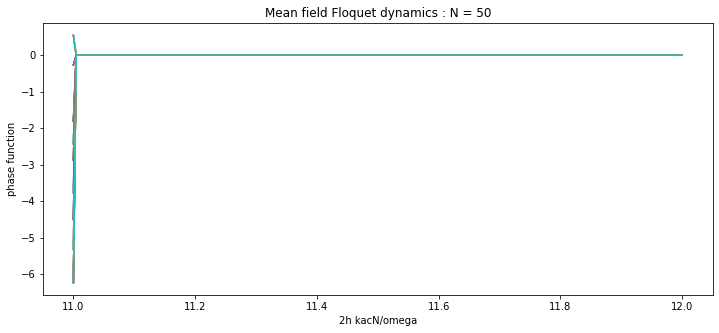

In [13]:
# experient 

# try to write "specific path" code into MULTI PROCESS code
import numpy as np
from odeintw import odeintw
import matplotlib.pyplot as plt
from multiprocessing import Pool
from numpy.linalg import multi_dot, norm, eig
import math
import time

start = time.time() 
# Bessel's root : 2.40482555769577	5.52007811028631	8.65372791291101	11.7915344390142	14.9309177084877


N = 50
kacN = N
h0 = 0.1
h = 20
tsteps = 500
wsteps = 200
w1 = 2 * h * kacN/11.
w2 = 2 * h * kacN/12.
ws = np.linspace(w1,w2,wsteps)
wpp = (np.ones((N,len(ws))) * ws).T

psi = np.eye(N) + (1j) * np.zeros((N,N))
floqEvolution_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))
phasefunc_path = np.zeros(len(ws))

def delta_func(x,y):
        if ( x == y ):
            return 1.0
        else:
            return 0.0

def floq_jac(psi0, t, h, h0, H1, H0, w):    
    drive = h0 + h * np.cos(w * t)
    jac = 1j * (H0 + drive * H1)    
    return jac
        
def floq_func(psi0, t, h, h0, H1, H0, w):
    floq_h = np.dot(floq_jac(psi0, t, h, h0, H1, H0, w), psi0)
    return floq_h

def floq_proc(psi,H0,H1,h,ws,nn):
    pp = nn
    labelname = 'wave func_' + str(nn)
    filename = str(N) + '_wave_' + str(nn)+ '.txt'
    
    # calculate for first "w"
    w = ws[0]          
    T = 2 * np.pi /w
    t = np.linspace(0,T,tsteps)
    floqEvolution_mat = np.zeros((N,N)) + 1j * np.zeros((N,N))
    for mm in np.arange(N):
        psi0 = psi[mm]  
        psi_t = odeintw(floq_func,psi0,t,args=(h, h0, H1, H0, w), Dfun=floq_jac)
        floqEvolution_mat[mm] = psi_t[-1]         
    evals, evecs = eig(floqEvolution_mat)
    evecs = np.asarray(list(map(lambda x :x/np.linalg.norm(x),evecs)))
    phasefunc = 1j * np.log(evals[nn] + 1j * 0) * w/(2 * np.pi)
    evecs_path = evecs[nn]               
    phasefunc_path[0] = phasefunc.real
    
    # calculate for rest of the "ws"
    for cc, w in enumerate(ws[1:len(ws)]):  
        T = 2 * np.pi /w
        t = np.linspace(0,T,tsteps)
        floqEvolution_mat = np.zeros((N,N)) + 1j * np.zeros((N,N))        
        for mm in np.arange(N):
            psi0 = psi[mm]  
            psi_t = odeintw(floq_func,psi0,t,args=(h, h0, H1, H0, w), Dfun=floq_jac)
            floqEvolution_mat[mm] = psi_t[-1] 
        evals, evecs = eig(floqEvolution_mat)
        evecs = np.asarray(list(map(lambda x :x/np.linalg.norm(x),evecs)))
        prob = np.asarray(list(map(lambda x:np.dot(np.conjugate(evecs_path).T,x),evecs))).real
        for i,pr in enumerate(prob):
            if (pr == max(prob)):
                pp = i
                break
        evecs_path = evecs[nn]
        phasefunc = 1j * np.log(evals[pp] + 1j * 0) * w/(2 * np.pi)
        phasefunc_path[cc+1] = phasefunc.imag

    return phasefunc_path

if __name__ == '__main__':     
    nprocs = 3
    p = Pool(processes = nprocs) 
    H0 = np.zeros((N,N))
    H1 = np.zeros((N,N))
    print("running for N = ", N, "with",nprocs,"processors")  

    spin = 0.5 * np.arange(N)[-1]
    s = np.arange(-spin,spin+1) 
    H0 = np.diagflat(0.5 * s **2/kacN)  
    for i in range(N):
        for j in range(N):
            H1[i][j] = 0.5 * (np.sqrt(spin * (spin+1) - s[i] * (s[i]+1)) * delta_func(s[j],s[i]+1)\
                              + np.sqrt(spin * (spin+1) - s[i] * (s[i]-1)) * delta_func(s[j],s[i]-1))   
    data = p.starmap(floq_proc,[(psi,H0,H1,h,ws,nn) for nn in np.arange(N)]) 
    
    title = "Mean field Floquet dynamics : N = " + str(N)
    plt.figure(figsize = (12,5))
    for i in np.arange(N):
        plt.plot(2 * h * kacN /ws, data[i])
    plt.title(title)    
    plt.xlabel("2h kacN/omega")
    plt.ylabel("phase function")
    plt.show()    